In [2]:
from os import path
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Định nghĩa đường dẫn
DATA_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\data"
RESULT_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\results"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [ ]:
# CONFIG

ViABSA_BP_dir = path.join(DATA_DIR, 'ViABSA_BP')

train_file = path.join(ViABSA_BP_dir, 'data_train.csv')
test_file = path.join(ViABSA_BP_dir, 'data_test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [4]:
# SETUP DATA

aspects = ['stayingpower', 'texture', 'smell', 'price', 'others', 'colour', 'shipping', 'packing']

train_df[aspects] = train_df[aspects].fillna('none')
test_df[aspects] = test_df[aspects].fillna('none')


for aspect in aspects:
    train_df[aspect + '_label'] = (train_df[aspect] != 'none').astype(int)
    test_df[aspect + '_label'] = (test_df[aspect] != 'none').astype(int)

aspect_labels = [aspect + '_label' for aspect in aspects]

X_train = train_df['data']
y_train_aspect = train_df[aspect_labels]
X_test = test_df['data']
y_test_aspect = test_df[aspect_labels]

In [ ]:
train_df.head()

,data,stayingpower,texture,smell,price,others,colour,shipping,packing,stayingpower_label,texture_label,smell_label,price_label,others_label,colour_label,shipping_label,packing_label
0,"son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...",none,none,none,none,none,none,positive,none,0,0,0,0,0,0,1,0
1,Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...,none,positive,positive,positive,none,none,none,none,0,1,1,1,0,0,0,0
2,"Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...",none,negative,none,none,none,positive,none,none,0,1,0,0,0,1,0,0
3,Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...,positive,positive,none,none,none,positive,none,none,1,1,0,0,0,1,0,0
4,"Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...",none,none,none,none,none,none,none,positive,0,0,0,0,0,0,0,1


In [6]:
print(X_train.shape)
print(y_train_aspect.shape)
print(X_test.shape)
print(y_test_aspect.shape)

(12981,)
(12981, 8)
(1623,)
(1623, 8)


In [7]:
# Pipeline phát hiện khía cạnh (multi-label)
pipeline_aspect = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultiOutputClassifier(LogisticRegression(solver='liblinear')))
])

# Huấn luyện mô hình
pipeline_aspect.fit(X_train, y_train_aspect)

# Dự đoán khía cạnh trên test set
y_pred_aspect = pipeline_aspect.predict(X_test)

In [8]:
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro') 
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")


F1_ad (Aspect Detection): 0.9307



Confusion matrix cho khía cạnh 'stayingpower':


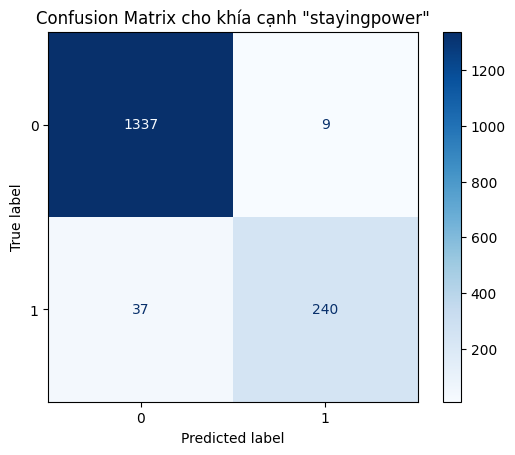

In [9]:
# In confusion matrix cho từng khía cạnh (chọn 1 khía cạnh ví dụ: 'texture')
# 'stayingpower', 'texture', 'smell', 'price', 'others', 'colour', 'shipping', 'packing'
aspect = 'stayingpower'
idx = aspects.index(aspect)
print(f"\nConfusion matrix cho khía cạnh '{aspect}':")

cm = confusion_matrix(y_test_aspect[aspect + '_label'], y_pred_aspect[:, idx])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix cho khía cạnh "{aspect}"')
plt.show()

In [10]:
# Map nhãn cảm xúc thành số
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'none': -1}

# Chuẩn bị y_train_sentiment và y_test_sentiment
y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects:
    y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
    y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

# Huấn luyện bộ phân loại cảm xúc cho từng khía cạnh
pipeline_sentiment = {}
for aspect in aspects:
    # Chọn mẫu có khía cạnh trong tập train
    mask_train = y_train_aspect[aspect + '_label'] == 1
    X_train_aspect = X_train[mask_train]
    y_train_aspect_sent = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 0:
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
        ])
        pipe.fit(X_train_aspect, y_train_aspect_sent)
        pipeline_sentiment[aspect] = pipe
    else:
        pipeline_sentiment[aspect] = None

# Dự đoán cảm xúc cho từng khía cạnh trên test set
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspects)), -1)  # -1 nghĩa là không dự đoán

for i, aspect in enumerate(aspects):
    pipe = pipeline_sentiment[aspect]
    if pipe is not None:
        mask_pred = y_pred_aspect[:, i] == 1
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred]
            y_pred_sentiment[mask_pred, i] = pipe.predict(X_test_aspect)

c:\Users\Admin\Python\ABSA_Prompting\.venv\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(


In [11]:
# Tính F1_sc cho từng khía cạnh và trung bình
f1_sc_list = []
for i, aspect in enumerate(aspects):
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, trung bình): {f1_sc:.4f}")

F1_sc (stayingpower): 0.7485
F1_sc (texture): 0.7848
F1_sc (smell): 0.8423
F1_sc (price): 0.9844
F1_sc (others): 1.0000
F1_sc (colour): 0.8507
F1_sc (shipping): 0.9061
F1_sc (packing): 0.9593

F1_sc (Sentiment Classification, trung bình): 0.8845


In [12]:
# F1_ad: F1-score trung bình trên tất cả các khía cạnh (multi-label)
f1_ad = f1_score(y_test_aspect, y_pred_aspect, average='micro')

# F1_sc: F1-score trung bình trên tất cả các khía cạnh và cảm xúc (chỉ tính trên các khía cạnh được dự đoán và có nhãn cảm xúc hợp lệ)
f1_sc_list = []
for i, aspect in enumerate(aspects):
    # Chọn mẫu có khía cạnh được dự đoán và có nhãn cảm xúc hợp lệ (khác -1)
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)


In [13]:
# Kết quả cuối cùng

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0

print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")

F1_ad (Aspect Detection): 0.9307
F1_sc (Sentiment Classification): 0.8845


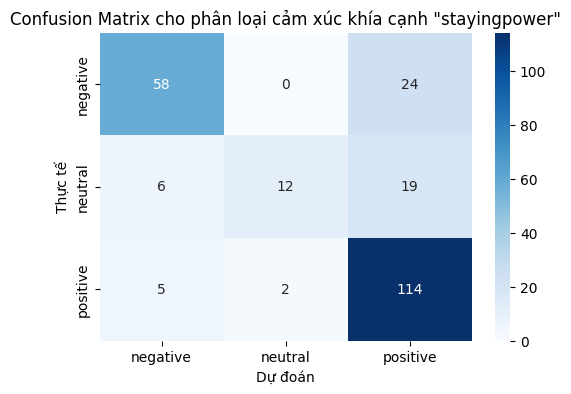

In [14]:
# Chọn 1 khía cạnh để minh họa (ví dụ: 'texture')
# 'stayingpower', 'texture', 'smell', 'price', 'others', 'colour', 'shipping', 'packing'
aspect = 'stayingpower'
idx = aspects.index(aspect)
mask = (y_pred_aspect[:, idx] == 1) & (y_test_sentiment[aspect] != -1)
cm = confusion_matrix(y_test_sentiment[aspect][mask], y_pred_sentiment[mask, idx])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title(f'Confusion Matrix cho phân loại cảm xúc khía cạnh "{aspect}"')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()